<a href="https://colab.research.google.com/github/zahraDehghanian97/pneumonia_dignosis/blob/master/pneumonia_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import pandas as pd       
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')
import random
import os
import glob
from numpy.random import seed
from tensorflow.random import set_seed

seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)

#Download data

In [86]:
 ! pip install -q kaggle

In [87]:
from google.colab import files
uploaded = files.upload()

In [88]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [89]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [90]:
!unzip /content/chest-xray-pneumonia.zip

Archive:  /content/chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
IMG_SIZE = 100
BATCH = 32
SEED = 42

#Reading data

In [ ]:
main_path = "/content/chest_xray/chest_xray"
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")
test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")
val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [ ]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])
df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]



#Previewing the images

In [ ]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

sampling to speed up

In [ ]:
# df = df_train.sample(frac=0.05)

# df_train, df_val = train_test_split(df, test_size = 0.20, random_state = SEED, stratify = df['class'])



#Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(df_train,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(df_val,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)



In [ ]:
val_df_1 = val_datagen.flow_from_dataframe(df_val,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            seed = SEED)

In [ ]:
val = []
for i in range(len(val_df_1.labels)):
  val.append(val_df_1.next()[0][0])
val

#Callbacks

In [ ]:
from tf_explain.callbacks.grad_cam import GradCAMCallback

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 
gradcam =     GradCAMCallback(
        validation_data=(val, val_df_1.labels),
        layer_name="input_1",
        class_index= 0,
        output_dir='content',
    )


#Resnet

In [ ]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

In [102]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],#,gradcam],
          steps_per_epoch=(float(len(train_df)/BATCH)),
          validation_steps=(float(len(val_df)/BATCH)));

Epoch 1/50
7/6 [================================] - ETA: 0s - loss: 0.8160 - binary_accuracy: 0.6250

6/6 [==============================] - 65s 1s/step - loss: 0.8160 - binary_accuracy: 0.6250 - val_loss: 0.7900 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 2/50
7/6 [================================] - ETA: 0s - loss: 0.5747 - binary_accuracy: 0.7411

6/6 [==============================] - 3s 495ms/step - loss: 0.5747 - binary_accuracy: 0.7411 - lr: 5.0000e-05
Epoch 3/50
7/6 [================================] - ETA: 0s - loss: 0.5109 - binary_accuracy: 0.7321

6/6 [==============================] - 3s 505ms/step - loss: 0.5109 - binary_accuracy: 0.7321 - lr: 5.0000e-05
Epoch 4/50
7/6 [================================] - ETA: 0s - loss: 0.4200 - binary_accuracy: 0.8214

6/6 [==============================] - 3s 460ms/step - loss: 0.4200 - binary_accuracy: 0.8214 - lr: 5.0000e-05
Epoch 5/50
7/6 [================================] - ETA: 0s - loss: 0.4025 - binary_accuracy: 0.8170

6/6 [==============================] - 3s 488ms/step - loss: 0.4025 - binary_accuracy: 0.8170 - lr: 5.0000e-05
Epoch 6/50
7/6 [================================] - ETA: 0s - loss: 0.3976 - binary_accuracy: 0.8259

6/6 [==============================] - 3s 490ms/step - loss: 0.3976 - binary_accuracy: 0.8259 - lr: 5.0000e-05
Epoch 7/50
7/6 [================================] - ETA: 0s - loss: 0.3332 - binary_accuracy: 0.8527

6/6 [==============================] - 3s 473ms/step - loss: 0.3332 - binary_accuracy: 0.8527 - lr: 5.0000e-05
Epoch 8/50
7/6 [================================] - ETA: 0s - loss: 0.3918 - binary_accuracy: 0.8214

6/6 [==============================] - 3s 516ms/step - loss: 0.3918 - binary_accuracy: 0.8214 - lr: 5.0000e-05
Epoch 9/50
7/6 [================================] - ETA: 0s - loss: 0.2910 - binary_accuracy: 0.8839

6/6 [==============================] - 3s 492ms/step - loss: 0.2910 - binary_accuracy: 0.8839 - lr: 5.0000e-05
Epoch 10/50
7/6 [================================] - ETA: 0s - loss: 0.2810 - binary_accuracy: 0.8795

6/6 [==============================] - 3s 475ms/step - loss: 0.2810 - binary_accuracy: 0.8795 - lr: 5.0000e-05
Epoch 11/50
7/6 [================================] - ETA: 0s - loss: 0.2560 - binary_accuracy: 0.8884

6/6 [==============================] - 3s 478ms/step - loss: 0.2560 - binary_accuracy: 0.8884 - lr: 5.0000e-05
Epoch 12/50
7/6 [================================] - ETA: 0s - loss: 0.3625 - binary_accuracy: 0.8348

6/6 [==============================] - 3s 528ms/step - loss: 0.3625 - binary_accuracy: 0.8348 - lr: 5.0000e-05
Epoch 13/50
7/6 [================================] - ETA: 0s - loss: 0.3055 - binary_accuracy: 0.8839

6/6 [==============================] - 3s 493ms/step - loss: 0.3055 - binary_accuracy: 0.8839 - lr: 5.0000e-05
Epoch 14/50
7/6 [================================] - ETA: 0s - loss: 0.2572 - binary_accuracy: 0.8705

6/6 [==============================] - 3s 489ms/step - loss: 0.2572 - binary_accuracy: 0.8705 - lr: 5.0000e-05
Epoch 15/50
7/6 [================================] - ETA: 0s - loss: 0.2363 - binary_accuracy: 0.9018

6/6 [==============================] - 3s 511ms/step - loss: 0.2363 - binary_accuracy: 0.9018 - lr: 5.0000e-05
Epoch 16/50
7/6 [================================] - ETA: 0s - loss: 0.2340 - binary_accuracy: 0.8929

6/6 [==============================] - 3s 506ms/step - loss: 0.2340 - binary_accuracy: 0.8929 - lr: 5.0000e-05
Epoch 17/50
7/6 [================================] - ETA: 0s - loss: 0.2408 - binary_accuracy: 0.9018

6/6 [==============================] - 3s 480ms/step - loss: 0.2408 - binary_accuracy: 0.9018 - lr: 5.0000e-05
Epoch 18/50
7/6 [================================] - ETA: 0s - loss: 0.3199 - binary_accuracy: 0.8661

6/6 [==============================] - 3s 530ms/step - loss: 0.3199 - binary_accuracy: 0.8661 - lr: 5.0000e-05
Epoch 19/50
7/6 [================================] - ETA: 0s - loss: 0.2806 - binary_accuracy: 0.8616

6/6 [==============================] - 4s 568ms/step - loss: 0.2806 - binary_accuracy: 0.8616 - lr: 5.0000e-05
Epoch 20/50
7/6 [================================] - ETA: 0s - loss: 0.2070 - binary_accuracy: 0.9420

6/6 [==============================] - 3s 484ms/step - loss: 0.2070 - binary_accuracy: 0.9420 - lr: 5.0000e-05
Epoch 21/50
7/6 [================================] - ETA: 0s - loss: 0.2503 - binary_accuracy: 0.8973

6/6 [==============================] - 3s 513ms/step - loss: 0.2503 - binary_accuracy: 0.8973 - lr: 5.0000e-05
Epoch 22/50
7/6 [================================] - ETA: 0s - loss: 0.3133 - binary_accuracy: 0.8929

6/6 [==============================] - 3s 493ms/step - loss: 0.3133 - binary_accuracy: 0.8929 - lr: 5.0000e-05
Epoch 23/50
7/6 [================================] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.8839

6/6 [==============================] - 3s 504ms/step - loss: 0.2445 - binary_accuracy: 0.8839 - lr: 5.0000e-05
Epoch 24/50
7/6 [================================] - ETA: 0s - loss: 0.2576 - binary_accuracy: 0.8884

6/6 [==============================] - 3s 507ms/step - loss: 0.2576 - binary_accuracy: 0.8884 - lr: 5.0000e-05
Epoch 25/50
7/6 [================================] - ETA: 0s - loss: 0.2864 - binary_accuracy: 0.8705

6/6 [==============================] - 3s 503ms/step - loss: 0.2864 - binary_accuracy: 0.8705 - lr: 5.0000e-05
Epoch 26/50
7/6 [================================] - ETA: 0s - loss: 0.1829 - binary_accuracy: 0.9196

6/6 [==============================] - 3s 471ms/step - loss: 0.1829 - binary_accuracy: 0.9196 - lr: 5.0000e-05
Epoch 27/50
7/6 [================================] - ETA: 0s - loss: 0.1871 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 507ms/step - loss: 0.1871 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 28/50
7/6 [================================] - ETA: 0s - loss: 0.1836 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 500ms/step - loss: 0.1836 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 29/50
7/6 [================================] - ETA: 0s - loss: 0.2524 - binary_accuracy: 0.8795

6/6 [==============================] - 3s 500ms/step - loss: 0.2524 - binary_accuracy: 0.8795 - lr: 5.0000e-05
Epoch 30/50
7/6 [================================] - ETA: 0s - loss: 0.1742 - binary_accuracy: 0.9464

6/6 [==============================] - 3s 476ms/step - loss: 0.1742 - binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 31/50
7/6 [================================] - ETA: 0s - loss: 0.1751 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 485ms/step - loss: 0.1751 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 32/50
7/6 [================================] - ETA: 0s - loss: 0.1870 - binary_accuracy: 0.9375

6/6 [==============================] - 3s 481ms/step - loss: 0.1870 - binary_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 33/50
7/6 [================================] - ETA: 0s - loss: 0.2506 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 481ms/step - loss: 0.2506 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 34/50
7/6 [================================] - ETA: 0s - loss: 0.1673 - binary_accuracy: 0.9375

6/6 [==============================] - 3s 478ms/step - loss: 0.1673 - binary_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 35/50
7/6 [================================] - ETA: 0s - loss: 0.2121 - binary_accuracy: 0.9062

6/6 [==============================] - 3s 491ms/step - loss: 0.2121 - binary_accuracy: 0.9062 - lr: 5.0000e-05
Epoch 36/50
7/6 [================================] - ETA: 0s - loss: 0.2115 - binary_accuracy: 0.9241

6/6 [==============================] - 3s 459ms/step - loss: 0.2115 - binary_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 37/50
7/6 [================================] - ETA: 0s - loss: 0.2271 - binary_accuracy: 0.9107

6/6 [==============================] - 3s 485ms/step - loss: 0.2271 - binary_accuracy: 0.9107 - lr: 5.0000e-05
Epoch 38/50
7/6 [================================] - ETA: 0s - loss: 0.2961 - binary_accuracy: 0.8929

6/6 [==============================] - 3s 478ms/step - loss: 0.2961 - binary_accuracy: 0.8929 - lr: 5.0000e-05
Epoch 39/50
7/6 [================================] - ETA: 0s - loss: 0.1656 - binary_accuracy: 0.9420

6/6 [==============================] - 3s 484ms/step - loss: 0.1656 - binary_accuracy: 0.9420 - lr: 5.0000e-05
Epoch 40/50
7/6 [================================] - ETA: 0s - loss: 0.2334 - binary_accuracy: 0.9018

6/6 [==============================] - 3s 513ms/step - loss: 0.2334 - binary_accuracy: 0.9018 - lr: 5.0000e-05
Epoch 41/50
7/6 [================================] - ETA: 0s - loss: 0.1961 - binary_accuracy: 0.9196

6/6 [==============================] - 3s 510ms/step - loss: 0.1961 - binary_accuracy: 0.9196 - lr: 5.0000e-05
Epoch 42/50
7/6 [================================] - ETA: 0s - loss: 0.2171 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 480ms/step - loss: 0.2171 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 43/50
7/6 [================================] - ETA: 0s - loss: 0.1990 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 471ms/step - loss: 0.1990 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 44/50
7/6 [================================] - ETA: 0s - loss: 0.2023 - binary_accuracy: 0.9062

6/6 [==============================] - 3s 514ms/step - loss: 0.2023 - binary_accuracy: 0.9062 - lr: 5.0000e-05
Epoch 45/50
7/6 [================================] - ETA: 0s - loss: 0.2080 - binary_accuracy: 0.9196

6/6 [==============================] - 4s 561ms/step - loss: 0.2080 - binary_accuracy: 0.9196 - lr: 5.0000e-05
Epoch 46/50
7/6 [================================] - ETA: 0s - loss: 0.1738 - binary_accuracy: 0.9062

6/6 [==============================] - 3s 474ms/step - loss: 0.1738 - binary_accuracy: 0.9062 - lr: 5.0000e-05
Epoch 47/50
7/6 [================================] - ETA: 0s - loss: 0.2679 - binary_accuracy: 0.8973

6/6 [==============================] - 3s 483ms/step - loss: 0.2679 - binary_accuracy: 0.8973 - lr: 5.0000e-05
Epoch 48/50
7/6 [================================] - ETA: 0s - loss: 0.1887 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 511ms/step - loss: 0.1887 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 49/50
7/6 [================================] - ETA: 0s - loss: 0.2046 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 490ms/step - loss: 0.2046 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 50/50
7/6 [================================] - ETA: 0s - loss: 0.2289 - binary_accuracy: 0.9196

6/6 [==============================] - 3s 497ms/step - loss: 0.2289 - binary_accuracy: 0.9196 - lr: 5.0000e-05


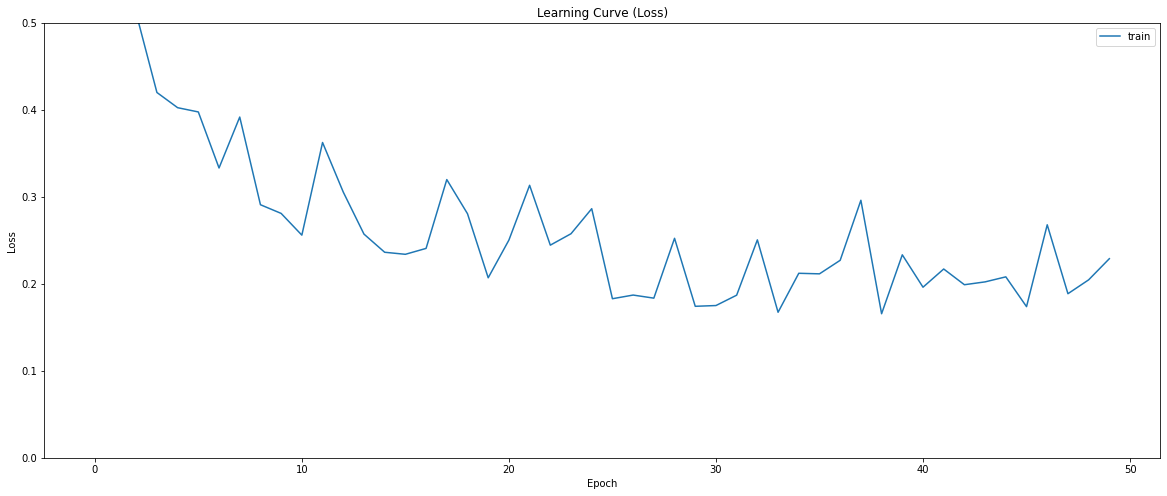

In [104]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
# sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

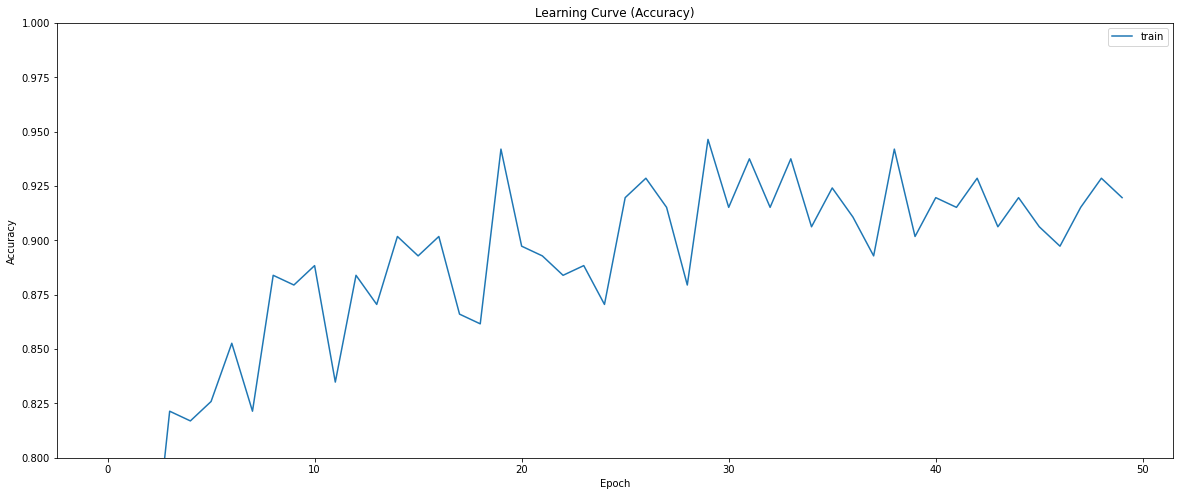

In [106]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
# sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [107]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.3304332494735718
Val accuracy: 0.875


In [108]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.467965304851532
Test accuracy: 0.8108974099159241


#Fine Tuning

In [109]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [110]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [111]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
7/6 [================================] - ETA: 0s - loss: 0.1634 - binary_accuracy: 0.9196

6/6 [==============================] - 4s 696ms/step - loss: 0.1634 - binary_accuracy: 0.9196 - val_loss: 0.4148 - val_binary_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 2/50
7/6 [================================] - ETA: 0s - loss: 0.2286 - binary_accuracy: 0.9107

6/6 [==============================] - 3s 521ms/step - loss: 0.2286 - binary_accuracy: 0.9107 - lr: 5.0000e-05
Epoch 3/50
7/6 [================================] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9107

6/6 [==============================] - 3s 486ms/step - loss: 0.2314 - binary_accuracy: 0.9107 - lr: 5.0000e-05
Epoch 4/50
7/6 [================================] - ETA: 0s - loss: 0.2930 - binary_accuracy: 0.8750

6/6 [==============================] - 3s 523ms/step - loss: 0.2930 - binary_accuracy: 0.8750 - lr: 5.0000e-05
Epoch 5/50
7/6 [================================] - ETA: 0s - loss: 0.1251 - binary_accuracy: 0.9464

6/6 [==============================] - 3s 485ms/step - loss: 0.1251 - binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 6/50
7/6 [================================] - ETA: 0s - loss: 0.1879 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 502ms/step - loss: 0.1879 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 7/50
7/6 [================================] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8750

6/6 [==============================] - 3s 533ms/step - loss: 0.3103 - binary_accuracy: 0.8750 - lr: 5.0000e-05
Epoch 8/50
7/6 [================================] - ETA: 0s - loss: 0.1229 - binary_accuracy: 0.9554

6/6 [==============================] - 3s 470ms/step - loss: 0.1229 - binary_accuracy: 0.9554 - lr: 5.0000e-05
Epoch 9/50
7/6 [================================] - ETA: 0s - loss: 0.2204 - binary_accuracy: 0.9062

6/6 [==============================] - 3s 486ms/step - loss: 0.2204 - binary_accuracy: 0.9062 - lr: 5.0000e-05
Epoch 10/50
7/6 [================================] - ETA: 0s - loss: 0.1429 - binary_accuracy: 0.9598

6/6 [==============================] - 3s 490ms/step - loss: 0.1429 - binary_accuracy: 0.9598 - lr: 5.0000e-05
Epoch 11/50
7/6 [================================] - ETA: 0s - loss: 0.2137 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 478ms/step - loss: 0.2137 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 12/50
7/6 [================================] - ETA: 0s - loss: 0.1775 - binary_accuracy: 0.9241

6/6 [==============================] - 3s 504ms/step - loss: 0.1775 - binary_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 13/50
7/6 [================================] - ETA: 0s - loss: 0.2345 - binary_accuracy: 0.8884

6/6 [==============================] - 3s 484ms/step - loss: 0.2345 - binary_accuracy: 0.8884 - lr: 5.0000e-05
Epoch 14/50
7/6 [================================] - ETA: 0s - loss: 0.2767 - binary_accuracy: 0.8839

6/6 [==============================] - 3s 523ms/step - loss: 0.2767 - binary_accuracy: 0.8839 - lr: 5.0000e-05
Epoch 15/50
7/6 [================================] - ETA: 0s - loss: 0.1605 - binary_accuracy: 0.9375

6/6 [==============================] - 3s 488ms/step - loss: 0.1605 - binary_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 16/50
7/6 [================================] - ETA: 0s - loss: 0.1753 - binary_accuracy: 0.9330

6/6 [==============================] - 3s 500ms/step - loss: 0.1753 - binary_accuracy: 0.9330 - lr: 5.0000e-05
Epoch 17/50
7/6 [================================] - ETA: 0s - loss: 0.1712 - binary_accuracy: 0.9241

6/6 [==============================] - 3s 502ms/step - loss: 0.1712 - binary_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 18/50
7/6 [================================] - ETA: 0s - loss: 0.1613 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 493ms/step - loss: 0.1613 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 19/50
7/6 [================================] - ETA: 0s - loss: 0.1729 - binary_accuracy: 0.9375

6/6 [==============================] - 4s 599ms/step - loss: 0.1729 - binary_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 20/50
7/6 [================================] - ETA: 0s - loss: 0.1626 - binary_accuracy: 0.9375

6/6 [==============================] - 3s 471ms/step - loss: 0.1626 - binary_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 21/50
7/6 [================================] - ETA: 0s - loss: 0.1368 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 503ms/step - loss: 0.1368 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 22/50
7/6 [================================] - ETA: 0s - loss: 0.1723 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 473ms/step - loss: 0.1723 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 23/50
7/6 [================================] - ETA: 0s - loss: 0.2039 - binary_accuracy: 0.9107

6/6 [==============================] - 3s 477ms/step - loss: 0.2039 - binary_accuracy: 0.9107 - lr: 5.0000e-05
Epoch 24/50
7/6 [================================] - ETA: 0s - loss: 0.2032 - binary_accuracy: 0.9420

6/6 [==============================] - 3s 463ms/step - loss: 0.2032 - binary_accuracy: 0.9420 - lr: 5.0000e-05
Epoch 25/50
7/6 [================================] - ETA: 0s - loss: 0.2131 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 493ms/step - loss: 0.2131 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 26/50
7/6 [================================] - ETA: 0s - loss: 0.1844 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 517ms/step - loss: 0.1844 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 27/50
7/6 [================================] - ETA: 0s - loss: 0.1408 - binary_accuracy: 0.9375

6/6 [==============================] - 3s 461ms/step - loss: 0.1408 - binary_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 28/50
7/6 [================================] - ETA: 0s - loss: 0.1751 - binary_accuracy: 0.9241

6/6 [==============================] - 3s 478ms/step - loss: 0.1751 - binary_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 29/50
7/6 [================================] - ETA: 0s - loss: 0.1670 - binary_accuracy: 0.9375

6/6 [==============================] - 3s 503ms/step - loss: 0.1670 - binary_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 30/50
7/6 [================================] - ETA: 0s - loss: 0.1612 - binary_accuracy: 0.9420

6/6 [==============================] - 3s 488ms/step - loss: 0.1612 - binary_accuracy: 0.9420 - lr: 5.0000e-05
Epoch 31/50
7/6 [================================] - ETA: 0s - loss: 0.2442 - binary_accuracy: 0.9018

6/6 [==============================] - 3s 499ms/step - loss: 0.2442 - binary_accuracy: 0.9018 - lr: 5.0000e-05
Epoch 32/50
7/6 [================================] - ETA: 0s - loss: 0.2047 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 486ms/step - loss: 0.2047 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 33/50
7/6 [================================] - ETA: 0s - loss: 0.1687 - binary_accuracy: 0.9196

6/6 [==============================] - 3s 480ms/step - loss: 0.1687 - binary_accuracy: 0.9196 - lr: 5.0000e-05
Epoch 34/50
7/6 [================================] - ETA: 0s - loss: 0.1901 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 531ms/step - loss: 0.1901 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 35/50
7/6 [================================] - ETA: 0s - loss: 0.1535 - binary_accuracy: 0.9420

6/6 [==============================] - 3s 489ms/step - loss: 0.1535 - binary_accuracy: 0.9420 - lr: 5.0000e-05
Epoch 36/50
7/6 [================================] - ETA: 0s - loss: 0.1446 - binary_accuracy: 0.9464

6/6 [==============================] - 3s 492ms/step - loss: 0.1446 - binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 37/50
7/6 [================================] - ETA: 0s - loss: 0.1787 - binary_accuracy: 0.9286

6/6 [==============================] - 3s 479ms/step - loss: 0.1787 - binary_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 38/50
7/6 [================================] - ETA: 0s - loss: 0.1318 - binary_accuracy: 0.9554

6/6 [==============================] - 3s 455ms/step - loss: 0.1318 - binary_accuracy: 0.9554 - lr: 5.0000e-05
Epoch 39/50
7/6 [================================] - ETA: 0s - loss: 0.1510 - binary_accuracy: 0.9464

6/6 [==============================] - 3s 497ms/step - loss: 0.1510 - binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 40/50
7/6 [================================] - ETA: 0s - loss: 0.1603 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 496ms/step - loss: 0.1603 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 41/50
7/6 [================================] - ETA: 0s - loss: 0.1629 - binary_accuracy: 0.9241

6/6 [==============================] - 3s 477ms/step - loss: 0.1629 - binary_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 42/50
7/6 [================================] - ETA: 0s - loss: 0.1548 - binary_accuracy: 0.9464

6/6 [==============================] - 3s 488ms/step - loss: 0.1548 - binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 43/50
7/6 [================================] - ETA: 0s - loss: 0.2092 - binary_accuracy: 0.9196

6/6 [==============================] - 3s 534ms/step - loss: 0.2092 - binary_accuracy: 0.9196 - lr: 5.0000e-05
Epoch 44/50
7/6 [================================] - ETA: 0s - loss: 0.1762 - binary_accuracy: 0.9241

6/6 [==============================] - 3s 521ms/step - loss: 0.1762 - binary_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 45/50
7/6 [================================] - ETA: 0s - loss: 0.1394 - binary_accuracy: 0.9464

6/6 [==============================] - 3s 485ms/step - loss: 0.1394 - binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 46/50
7/6 [================================] - ETA: 0s - loss: 0.1813 - binary_accuracy: 0.9152

6/6 [==============================] - 3s 509ms/step - loss: 0.1813 - binary_accuracy: 0.9152 - lr: 5.0000e-05
Epoch 47/50
7/6 [================================] - ETA: 0s - loss: 0.1247 - binary_accuracy: 0.9554

6/6 [==============================] - 6s 903ms/step - loss: 0.1247 - binary_accuracy: 0.9554 - lr: 5.0000e-05
Epoch 48/50
7/6 [================================] - ETA: 0s - loss: 0.2056 - binary_accuracy: 0.9241

6/6 [==============================] - 3s 513ms/step - loss: 0.2056 - binary_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 49/50
7/6 [================================] - ETA: 0s - loss: 0.1784 - binary_accuracy: 0.9196

6/6 [==============================] - 3s 513ms/step - loss: 0.1784 - binary_accuracy: 0.9196 - lr: 5.0000e-05
Epoch 50/50
7/6 [================================] - ETA: 0s - loss: 0.1702 - binary_accuracy: 0.9330

6/6 [==============================] - 3s 465ms/step - loss: 0.1702 - binary_accuracy: 0.9330 - lr: 5.0000e-05


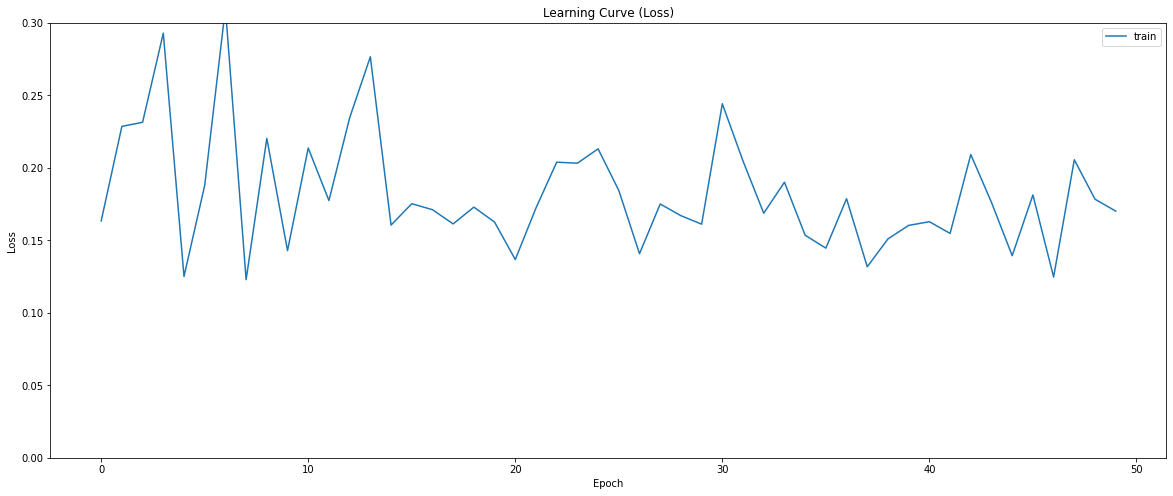

In [113]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
# sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()


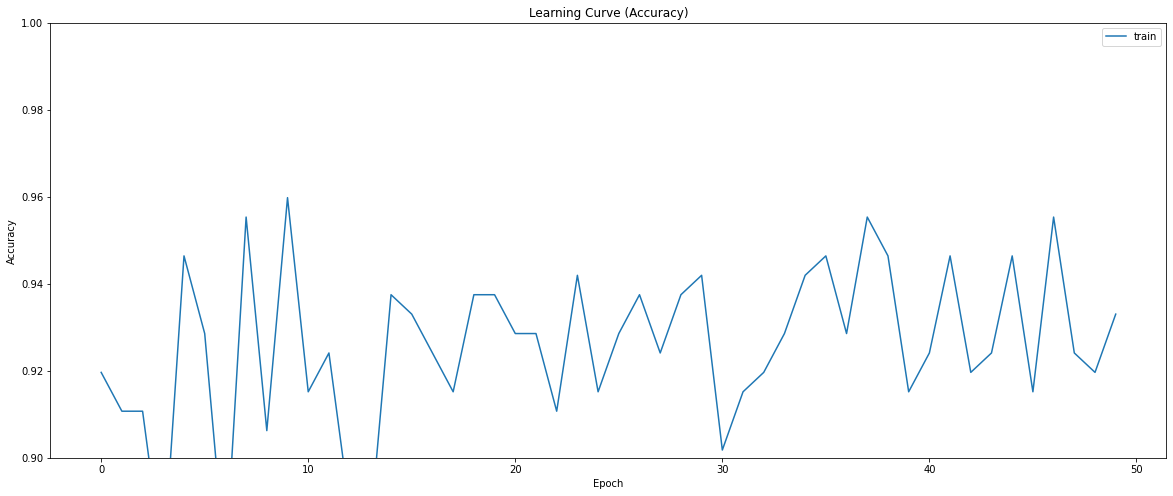

In [114]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
# sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [115]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.46333953738212585
Val accuracy: 0.8125


In [116]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4706278145313263
Test accuracy: 0.8108974099159241


#Evaluation

In [117]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [118]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [119]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8108974358974359


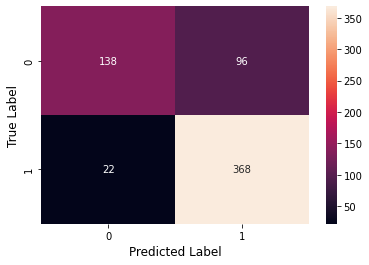

In [120]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()



In [121]:
print(classification_report(Y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.59      0.70       234
   Normal (Class 1)       0.79      0.94      0.86       390

           accuracy                           0.81       624
          macro avg       0.83      0.77      0.78       624
       weighted avg       0.82      0.81      0.80       624

